<a href="https://colab.research.google.com/github/SajidMajeed92/HISB-PROJECTS/blob/main/Rice_Classification_by_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [ ]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:
! kaggle datasets download -d muratkokludataset/rice-image-dataset

 93% 204M/219M [00:01<00:00, 128MB/s]
100% 219M/219M [00:01<00:00, 140MB/s]


In [ ]:
!ls

Grapevine_Leaves_Image_Dataset	rice-image-dataset.zip	seg_test
kaggle.json			seg_pred		seg_train


In [ ]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset --unzip

rice-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset --unzip --force

100% 219M/219M [00:04<00:00, 93.5MB/s]
100% 219M/219M [00:04<00:00, 51.5MB/s]


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pathlib

In [ ]:
tf.random.set_seed(42)
train_data = keras.utils.image_dataset_from_directory('/content/drive/My Drive/Kaggle/Rice_Image_Dataset/',
                                                 validation_split = 0.2,
                                                        subset = 'training',
                                                        seed = 1,
                                                        shuffle = True,
                                                        batch_size = 32,
                                                       image_size=(256,256))
test_data = keras.utils.image_dataset_from_directory('/content/drive/My Drive/Kaggle/Rice_Image_Dataset/',
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = 1,
                                                       shuffle = True,
                                                       batch_size = 32,
                                                    image_size=(256,256))

Found 75000 files belonging to 5 classes.
Using 60000 files for training.
Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


In [ ]:
filenames = pathlib.Path('/content/drive/My Drive/Kaggle/Rice_Image_Dataset/')
for label in train_data.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

Arborio : 15000
Basmati : 15000
Ipsala : 15000
Jasmine : 15000
Karacadag : 15000


In [ ]:
train_data.cardinality().numpy(),  test_data.cardinality().numpy()

(1875, 469)

In [ ]:
train_set = train_data.take(1500)
val_set = train_data.skip(1500)

In [ ]:
train_set.cardinality().numpy() ,val_set.cardinality().numpy()

(1500, 375)

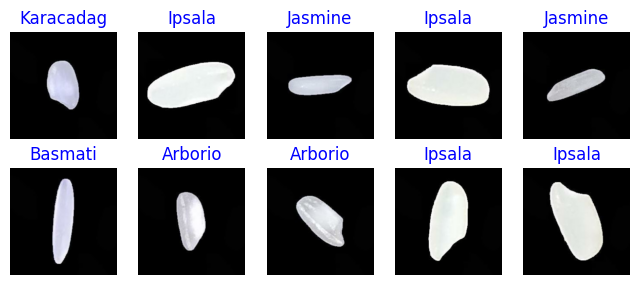

In [ ]:
BATCH_SIZE = 10
plt.figure(figsize=(8, 5))
for images, labels in train_set.take(1):
   for i in range(BATCH_SIZE):
    indx = random.randint(0, len(images))
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_data.class_names[labels[i]], color= 'blue', fontsize= 12)
    plt.axis(False)
plt.show()

Build a Model

In [ ]:
for images_batch, labels_batch in train_set:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [ ]:
from tensorflow.keras import layers

In [ ]:
tf.random.set_seed(42)

cnn_1 = keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(5, activation = 'sigmoid')
])

cnn_1.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_1 = cnn_1.fit(train_set, epochs = 5, validation_data = val_set)

Epoch 1/5
1500/1500 [==============================] - 249s 158ms/step - loss: 0.1905 - accuracy: 0.9624 - val_loss: 0.0585 - val_accuracy: 0.9797
Epoch 2/5
1500/1500 [==============================] - 249s 165ms/step - loss: 0.0378 - accuracy: 0.9876 - val_loss: 0.0423 - val_accuracy: 0.9858
Epoch 3/5
1500/1500 [==============================] - 235s 157ms/step - loss: 0.0266 - accuracy: 0.9907 - val_loss: 0.0402 - val_accuracy: 0.9878
Epoch 4/5
1500/1500 [==============================] - 234s 156ms/step - loss: 0.0157 - accuracy: 0.9944 - val_loss: 0.0665 - val_accuracy: 0.9814
Epoch 5/5
1500/1500 [==============================] - 235s 156ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0937 - val_accuracy: 0.9743


In [ ]:
cnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 500)               258064500 
                                                                 
 dense_1 (Dense)             (None, 5)                 2505      
                                                        

In [ ]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

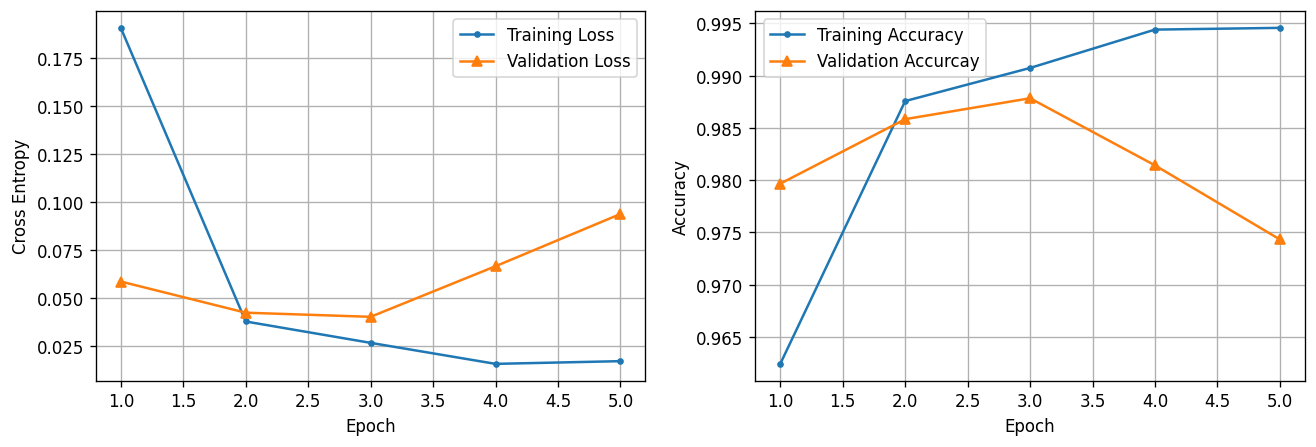

In [ ]:
plot_training_curves(pd.DataFrame(history_1.history))

In [ ]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)

X_test.shape, y_test.shape

(TensorShape([3200, 256, 256, 3]), TensorShape([3200]))

In [ ]:
from sklearn import metrics
y_pred_proba = cnn_1.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

100/100 [==============================] - 4s 36ms/step


In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9803125

In [ ]:
train_score = cnn_1.evaluate(train_data, verbose= 1)
test_score = cnn_1.evaluate(test_data, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('*****************************')
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

469/469 [==============================] - 38s 80ms/step - loss: 0.0936 - accuracy: 0.9750
Train Loss:  0.04799315333366394
Train Accuracy:  0.9839000105857849
*****************************
Test Loss:  0.09356718510389328
Test Accuracy:  0.9750000238418579


In [41]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       0.99      0.94      0.97       603
     Basmati       1.00      0.97      0.98       611
      Ipsala       1.00      0.99      1.00       642
     Jasmine       0.96      1.00      0.98       656
   Karacadag       0.96      1.00      0.98       688

    accuracy                           0.98      3200
   macro avg       0.98      0.98      0.98      3200
weighted avg       0.98      0.98      0.98      3200



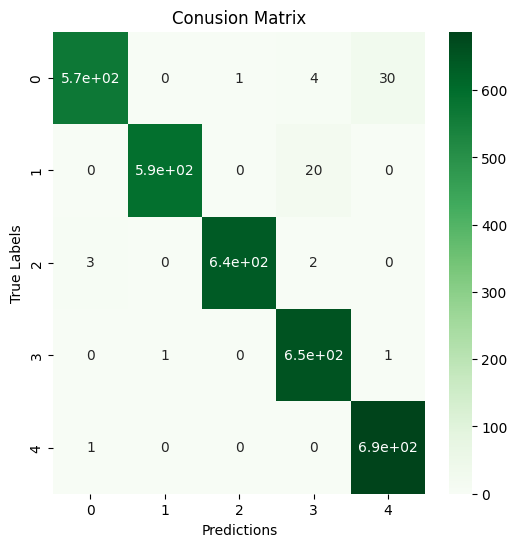

In [42]:
import seaborn as sns
plt.figure(figsize = (6,6), dpi = 100)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot = True, cmap = 'Greens')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Conusion Matrix')
plt.show()

In [43]:
# plot random images from a given dataset, and compare predictions with ground truth
def plot_random_predictions(dataset, model):

    shuffled_data = dataset.shuffle(10)
    class_names = dataset.class_names

    for images, labels in shuffled_data.take(1):
        plt.figure(figsize = (8, 8), dpi = 120)
        y_pred_proba = model.predict(images)

    for i in range(9):
        index = random.randint(0, len(images))
        ax = plt.subplot(3,3, i + 1)

        img = images[index].numpy().astype("uint8")
        y_true = class_names[labels[index]]
        y_pred = class_names[np.argmax(y_pred_proba[index], axis = 0)]

        c = 'g' if y_pred == y_true else 'r'

        plt.imshow(img)
        plt.title(f'Predicted : {y_pred}\nTrue label : {y_true}', c = c)
        plt.axis(False)

1/1 [==============================] - 0s 40ms/step


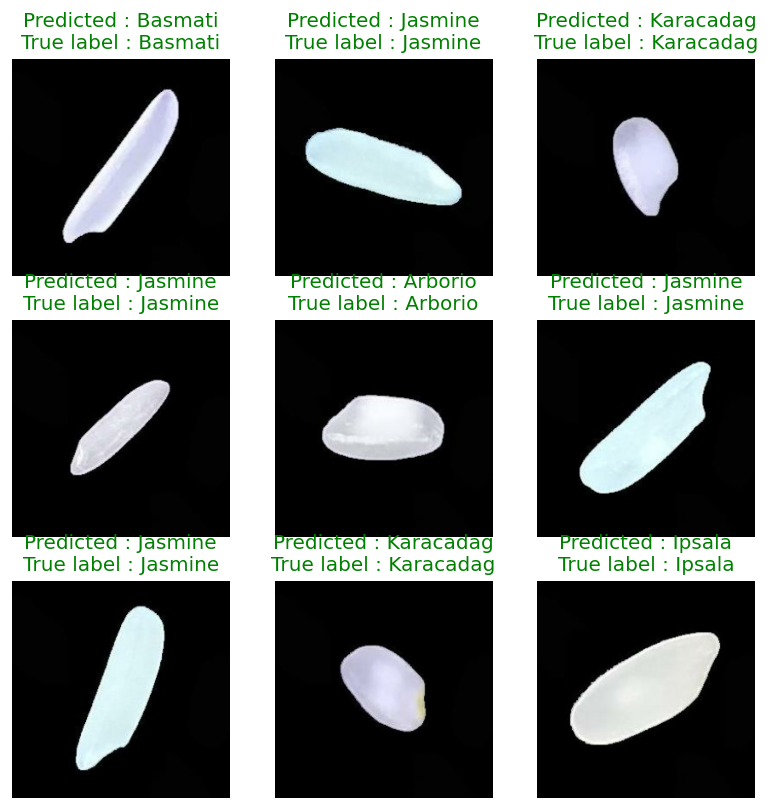

In [46]:
plot_random_predictions(test_data, cnn_1)